In [90]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Advanced Machine Learning Methods/Actividad 1.2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Advanced Machine Learning Methods/Actividad 1.2'
/content/drive/My Drive/Advanced Machine Learning Methods/Actividad 1.2


In [91]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
DATA_PATH = 'asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [93]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [94]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [95]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    """
    Split the given data into validation and test sets.

    Parameters:
    - x (array-like): Features of the validation set.
    - y (array-like): Labels of the validation set.
    - pct (float): Proportion of the data to be used as the test set.
    - shuffle (bool): Whether to shuffle the data before splitting.

    Returns:
    - x_val_new (array-like): Features for the new validation set.
    - x_test_new (array-like): Features for the test set.
    - y_val_new (array-like): Labels for the new validation set.
    - y_test_new (array-like): Labels for the test set.
    """

    if shuffle:
        random_idxs = np.random.permutation(len(x))
        x = x[random_idxs]
        y = y[random_idxs]

    # Calculate the split index
    split_idx = int(len(x) * (1 - pct))

    x_val_new = x[:split_idx]
    y_val_new = y[:split_idx]

    x_test_new = x[split_idx:]
    y_test_new = y[split_idx:]

    return x_val_new, x_test_new, y_val_new, y_test_new




In [96]:
# Splitting the validation set into new validation and test sets
x_val, x_test, y_val, y_test = split_val_test(x_val, y_val)

In [97]:
y_test

array([ 4, 16, 13, ...,  7, 23, 13])

La imagen muestreada representa un: 14


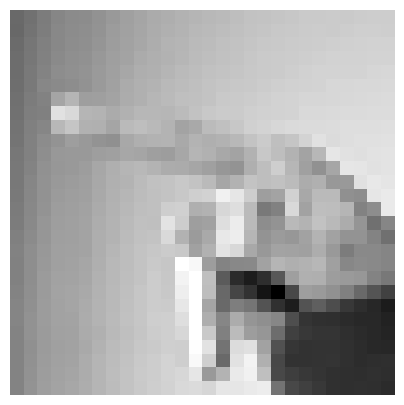

In [98]:
# Fixing the code to plot the number
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.reshape(28, 28), cmap=plt.get_cmap('gray'))  # Reshaping the image to 28x28
    plt.axis('off')
    plt.show()

rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx]}')
plot_number(x_test[rnd_idx])

In [99]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


In [100]:

def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [101]:
def create_minibatches(mb_size, x, y, shuffle=True):
    """
    Create mini-batches from the provided data.

    Parameters:
    - mb_size (int): Size of each mini-batch.
    - x (array-like): Features.
    - y (array-like): Labels.
    - shuffle (bool): Whether to shuffle the data before creating mini-batches.

    Returns:
    - generator: A generator that yields mini-batches of data.
    """
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]

    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]

    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Testing the function with training data
mb_size = 128
mini_batches = list(create_minibatches(mb_size, x_train, y_train))

# Displaying the shape of the first mini-batch
mini_batches[0][0].shape, mini_batches[0][1].shape


((128, 784), (128,))

In [102]:
class LayerBase:

  def forward(self, x):
    raise NotImplementedError

  def backward(self, grad):
    raise NotImplementedError

  def update(self, lr):
    pass # Not all layers will need updates (e.g. ReLU)


class Linear(LayerBase):
    def __init__(self, input_nodes, output_nodes):
        self.weights = np.random.normal(0.0, np.sqrt(2.0/input_nodes), (input_nodes, output_nodes))
        self.biases = np.zeros(output_nodes)
        self.dweights = np.zeros_like(self.weights)
        self.dbiases = np.zeros_like(self.biases)

    def forward(self, x):
        self.last_input = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, grad):
        # Adjust the gradient calculation
        self.dweights = np.dot(self.last_input.T, grad)
        self.dbiases = np.sum(grad, axis=0)
        return np.dot(grad, self.weights.T)

    def update(self, lr):
        self.weights -= lr * self.dweights
        self.biases -= lr * self.dbiases

    def zero_grad(self):
        """Reset gradients to zero."""
        self.dweights.fill(0)
        self.dbiases.fill(0)


class ReLU(LayerBase):
    def forward(self, x):
        self.last_input = x
        return np.maximum(0, x)

    def backward(self, grad):
        return grad * (self.last_input > 0)

class Network:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    def zero_grad(self):
        """Reset gradients of all layers to zero."""
        for layer in self.layers:
            if hasattr(layer, 'zero_grad'):
                layer.zero_grad()



In [103]:
def softmax(logits):
    e_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return e_logits / np.sum(e_logits, axis=1, keepdims=True)

def one_hot_encode(labels, num_classes):
    """One-hot encode a list of labels."""
    return np.eye(num_classes)[labels]

# Adjust the SoftmaxXEntropy layer to handle batches of data
class SoftmaxXEntropy(LayerBase):
    def forward(self, logits, targets):
        num_classes = logits.shape[1]

        # One-hot encode the targets
        targets_one_hot = one_hot_encode(targets, num_classes)
        self.last_targets = targets_one_hot  # Save the one-hot encoded targets

        self.last_softmax = softmax(logits)

        # Cross entropy loss
        return -np.sum(targets_one_hot * np.log(self.last_softmax + 1e-10)) / logits.shape[0]


    def backward(self, _=None):
      # Gradient of the softmax cross entropy loss
      return self.last_softmax - self.last_targets




class NeuralNetworkTrainer:
    def __init__(self, model, lr=0.01):
        self.model = model
        self.lr = lr
        self.loss_layer = SoftmaxXEntropy()

    def train(self, inputs, targets):
        # Forward pass
        logits = self.model.forward(inputs)

        # Compute loss
        loss = self.loss_layer.forward(logits, targets)

        # Backward pass
        grad = self.loss_layer.backward()
        self.model.backward(grad)

        # Update weights
        self.model.update(self.lr)

        return loss


In [104]:
model = Network([Linear(784, 128), ReLU(), Linear(128, 24)])
trainer = NeuralNetworkTrainer(model, lr=0.01)
model

In [105]:
def compute_accuracy(logits, targets):
    predictions = np.argmax(logits, axis=1)
    return np.mean(predictions == targets)


In [106]:
class Optimizer:
    def __init__(self, model, lr=0.01):
        self.model = model
        self.lr = lr

    def step(self):
        """Update model's weights using gradients calculated during backpropagation."""
        self.model.update(self.lr)

    def zero_grad(self, set_to_none=True):
        """Reset gradients of all layers to zero."""
        self.model.zero_grad()

# Create the optimizer
optimizer = Optimizer(model, lr=0.01)


num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    for xb, yb in create_minibatches(4, x_train, y_train): # Assuming create_minibatches yields mini-batches
        # Evaluate the loss
        logits = model.forward(xb)
        loss = trainer.loss_layer.forward(logits, yb)  # Use the loss layer in the trainer

        # Zero out the gradients
        optimizer.zero_grad()

        # Backward pass
        grad = trainer.loss_layer.backward()  # Use the loss layer in the trainer
        model.backward(grad)

        # Update weights using the optimizer
        optimizer.step()

        # Accumulate the loss for this epoch
        epoch_loss += loss
        num_batches += 1

    # Average the loss over all mini-batches
    epoch_loss /= num_batches

    # Compute validation accuracy
    val_logits = model.forward(x_val)
    val_accuracy = compute_accuracy(val_logits, y_val)

    # Print loss and accuracy
    print(f"Epoch {epoch+1}, Loss={epoch_loss:.4f}, Val Accuracy={val_accuracy*100:.2f}%")


Epoch 1, Loss=0.3747, Val Accuracy=81.43%
Epoch 2, Loss=0.0017, Val Accuracy=81.82%
Epoch 3, Loss=0.0009, Val Accuracy=82.07%
Epoch 4, Loss=0.0007, Val Accuracy=82.07%
Epoch 5, Loss=0.0005, Val Accuracy=82.54%
Epoch 6, Loss=0.0004, Val Accuracy=82.77%
Epoch 7, Loss=0.0004, Val Accuracy=82.88%
Epoch 8, Loss=0.0003, Val Accuracy=82.74%
Epoch 9, Loss=0.0003, Val Accuracy=82.79%
Epoch 10, Loss=0.0002, Val Accuracy=82.79%
